In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import shutil

In [ ]:
!unzip /content/drive/MyDrive/Datasets/OCT2017_dataset.zip

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 16
target_size = (224, 224)

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen= ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        '/content/OCT2017/train',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        '/content/OCT2017/val',
        target_size=target_size,
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical')

Found 83484 images belonging to 4 classes.
Found 32 images belonging to 4 classes.


# ResNet50

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Input,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy,categorical_crossentropy

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [ ]:
feature_extractor = ResNet50(weights='imagenet',
                          input_shape=(224, 224, 3),
                          include_top=False)
feature_extractor.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_14[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

unfreezing 2 layer

In [ ]:
for layer in feature_extractor.layers[0 :-7]:
    layer.trainable = False

feature_extractor.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_14[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
inp_layer = Input(shape = (224, 224, 3))
features = feature_extractor(inp_layer)

flat = Flatten()(features)
FC1 = Dense(units = 300, activation = 'relu')(flat)
FC2 = Dense(units = 200, activation = 'relu')(FC1)
output = Dense(units = 4, activation = 'softmax')(FC2)

model = Model(inputs = inp_layer, outputs = output)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_4 (Flatten)         (None, 100352)            0         
                                                                 
 dense_9 (Dense)             (None, 300)               30105900  
                                                                 
 dense_10 (Dense)            (None, 200)               60200     
                                                                 
 dense_11 (Dense)            (None, 4)                 804       
                                                                 
Total params: 53,754,616
Trainable params: 33,582,456
Non-t

In [ ]:
opt = Adam(learning_rate = 0.0001)
model.compile(optimizer = opt, loss=categorical_crossentropy, metrics = 'acc')

In [ ]:
results= model.fit(train_generator,
                    epochs = 10,
                    validation_data=validation_generator)

Epoch 1/10
5218/5218 [==============================] - 505s 94ms/step - loss: 0.8533 - acc: 0.6773 - val_loss: 1.4278 - val_acc: 0.4062
Epoch 2/10
5218/5218 [==============================] - 457s 88ms/step - loss: 0.7039 - acc: 0.7333 - val_loss: 0.8086 - val_acc: 0.6250
Epoch 3/10
5218/5218 [==============================] - 433s 83ms/step - loss: 0.6432 - acc: 0.7583 - val_loss: 0.8388 - val_acc: 0.7500
Epoch 4/10
5218/5218 [==============================] - 427s 82ms/step - loss: 0.5982 - acc: 0.7750 - val_loss: 0.3583 - val_acc: 0.8438
Epoch 5/10
5218/5218 [==============================] - 420s 80ms/step - loss: 0.5686 - acc: 0.7884 - val_loss: 0.6106 - val_acc: 0.7188
Epoch 6/10
5218/5218 [==============================] - 408s 78ms/step - loss: 0.5424 - acc: 0.7978 - val_loss: 0.4913 - val_acc: 0.7188
Epoch 7/10
5218/5218 [==============================] - 398s 76ms/step - loss: 0.5212 - acc: 0.8059 - val_loss: 0.4745 - val_acc: 0.7500
Epoch 8/10
5218/5218 [===================

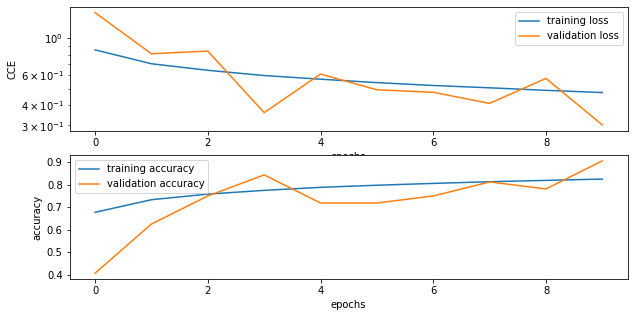

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

train_loss = results.history['loss']
val_loss = results.history['val_loss']
train_acc = results.history['acc']
val_acc = results.history['val_acc']

plt.subplots(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.semilogy(train_loss)
plt.semilogy(val_loss)

plt.legend(['training loss', 'validation loss'])
plt.xlabel('epochs')
plt.ylabel('CCE')

plt.subplot(2, 1, 2)
plt.plot(train_acc)
plt.plot(val_acc)

plt.legend(['training accuracy', 'validation accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.show()

In [ ]:
test_generator = test_datagen.flow_from_directory(
        '/content/OCT2017/test',
        target_size=target_size,
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [ ]:
y_pred_test = model.predict(test_generator)

In [ ]:
thresh = 0.5
y_pred_test[y_pred_test >= thresh] = 1
y_pred_test[y_pred_test < thresh]  = 0

In [ ]:
y_pred_test=np.argmax(y_pred_test,axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_generator.classes, y_pred_test))

[[241   0   1   0]
 [ 53 173   3  13]
 [ 97   1 140   4]
 [  1   5   5 231]]


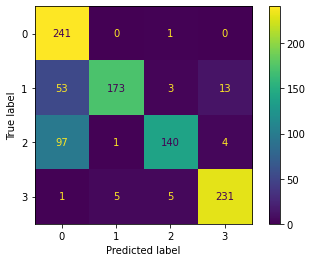

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(test_generator.classes, y_pred_test)

In [ ]:
from sklearn.metrics import classification_report
cls_report = classification_report(test_generator.classes, y_pred_test)

print(cls_report)

              precision    recall  f1-score   support

           0       0.61      1.00      0.76       242
           1       0.97      0.71      0.82       242
           2       0.94      0.58      0.72       242
           3       0.93      0.95      0.94       242

    accuracy                           0.81       968
   macro avg       0.86      0.81      0.81       968
weighted avg       0.86      0.81      0.81       968



results show impressive progress in various metrics

In [ ]:
import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = results.history
# Save it under the form of a json file
json.dump(history_dict, open('/content/drive/MyDrive/ResNet50_2.json', 'w'))

# InceptionV3

In [ ]:
from tensorflow.keras.applications.inception_v3  import InceptionV3
from tensorflow.keras.applications.inception_v3  import preprocess_input
from tensorflow.keras.layers import Input
import numpy as np

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Input,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy,categorical_crossentropy

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 16
target_size = (299, 299)

train_datagen2 = ImageDataGenerator(rescale=1./255)
val_datagen2 = ImageDataGenerator(rescale=1./255)

train_generator2 = train_datagen2.flow_from_directory(
        '/content/OCT2017/train',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical')

validation_generator2 = val_datagen2.flow_from_directory(
        '/content/OCT2017/val',
        target_size=target_size,
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical')

Found 83484 images belonging to 4 classes.
Found 32 images belonging to 4 classes.


In [ ]:
feature_extractor_Incept= InceptionV3(weights='imagenet',
                          input_shape=(299, 299, 3),
                          include_top=False)
feature_extractor_Incept.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 149, 149, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                      

unfreezing 2 layer

In [ ]:
for layer in feature_extractor_Incept.layers[0 :-17]:
    layer.trainable = False

feature_extractor_Incept.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 149, 149, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                      

In [ ]:
inp_layer = Input(shape = (299, 299, 3))
features2 = feature_extractor_Incept(inp_layer)

flat = Flatten()(features2)
FC1 = Dense(units = 300, activation = 'relu')(flat)
FC2 = Dense(units = 200, activation = 'relu')(FC1)
output = Dense(units = 4, activation = 'softmax')(FC2)

model2 = Model(inputs = inp_layer, outputs = output)

model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 300)               39321900  
                                                                 
 dense_1 (Dense)             (None, 200)               60200     
                                                                 
 dense_2 (Dense)             (None, 4)                 804       
                                                                 
Total params: 61,185,688
Trainable params: 40,433,528
Non-tra

In [ ]:
opt = Adam(learning_rate = 0.0001)
model2.compile(optimizer = opt, loss=categorical_crossentropy, metrics = 'acc')

In [ ]:
results_InceptionV3 = model2.fit(train_generator2,
                    epochs = 10,
                    validation_data=validation_generator2)

Epoch 1/10
5218/5218 [==============================] - 574s 107ms/step - loss: 0.3310 - acc: 0.8847 - val_loss: 0.0816 - val_acc: 0.9688
Epoch 2/10
5218/5218 [==============================] - 530s 102ms/step - loss: 0.1961 - acc: 0.9313 - val_loss: 0.0552 - val_acc: 0.9688
Epoch 3/10
5218/5218 [==============================] - 509s 98ms/step - loss: 0.1393 - acc: 0.9507 - val_loss: 0.0894 - val_acc: 0.9375
Epoch 4/10
5218/5218 [==============================] - 496s 95ms/step - loss: 0.1010 - acc: 0.9646 - val_loss: 0.0525 - val_acc: 0.9688
Epoch 5/10
5218/5218 [==============================] - 495s 95ms/step - loss: 0.0733 - acc: 0.9740 - val_loss: 0.0785 - val_acc: 0.9375
Epoch 6/10
5218/5218 [==============================] - 511s 98ms/step - loss: 0.0571 - acc: 0.9798 - val_loss: 0.0148 - val_acc: 1.0000
Epoch 7/10
5218/5218 [==============================] - 491s 94ms/step - loss: 0.0474 - acc: 0.9831 - val_loss: 0.0139 - val_acc: 1.0000
Epoch 8/10
5218/5218 [=================

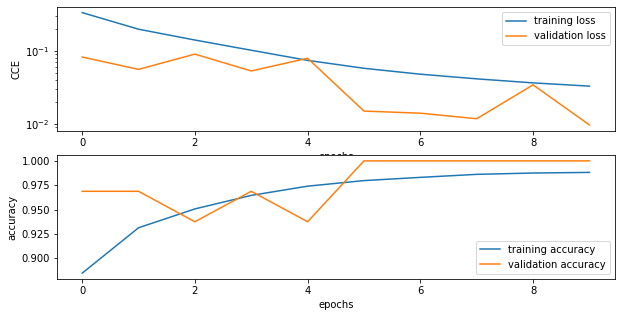

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

train_loss = results_InceptionV3.history['loss']
val_loss = results_InceptionV3.history['val_loss']
train_acc = results_InceptionV3.history['acc']
val_acc = results_InceptionV3.history['val_acc']

plt.subplots(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.semilogy(train_loss)
plt.semilogy(val_loss)

plt.legend(['training loss', 'validation loss'])
plt.xlabel('epochs')
plt.ylabel('CCE')

plt.subplot(2, 1, 2)
plt.plot(train_acc)
plt.plot(val_acc)

plt.legend(['training accuracy', 'validation accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.show()

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        '/content/OCT2017/test',
        target_size=target_size,
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [ ]:
y_pred_test_Incept = model2.predict(test_generator)

In [ ]:
thresh = 0.5
y_pred_test_Incept[y_pred_test_Incept >= thresh] = 1
y_pred_test_Incept[y_pred_test_Incept < thresh]  = 0

In [ ]:
y_pred_test_Incept=np.argmax(y_pred_test_Incept,axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_generator.classes, y_pred_test_Incept))

[[242   0   0   0]
 [  2 239   0   1]
 [  1   0 241   0]
 [  0   0   1 241]]


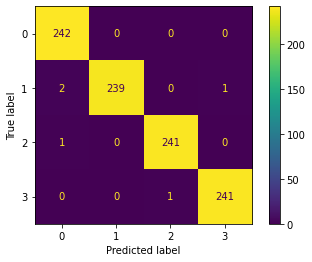

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(test_generator.classes, y_pred_test_Incept)

In [ ]:
from sklearn.metrics import classification_report
cls_report = classification_report(test_generator.classes, y_pred_test_Incept)

print(cls_report)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       242
           1       1.00      0.99      0.99       242
           2       1.00      1.00      1.00       242
           3       1.00      1.00      1.00       242

    accuracy                           0.99       968
   macro avg       0.99      0.99      0.99       968
weighted avg       0.99      0.99      0.99       968



inception model exprience some progress too and it denoted %99 in metrics that is excellent

In [ ]:
import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = results_InceptionV3.history
# Save it under the form of a json file
json.dump(history_dict, open('/content/drive/MyDrive/InceptionV3_2.json', 'w'))